In [1]:
# load packages
import pandas as pd
import pickle
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, concatenate, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

import keras.layers as layers

# set random seeds
np.random.seed(1)
tf.random.set_seed(2)


# Data preparation


In [2]:
import itertools

def load_data(level):
    data = pd.read_csv('/Users/r/Desktop/HFT project/ES 1.2-2.1 1s 15level LOB data/ES lob 1.2-2.1 15levels.csv', skiprows=0)
    
    levels = list(range(1, level + 1))
    iters = [iter(levels), iter(levels), iter(levels), iter(levels)]
    abv = ['ask_price', 'ask_volume', 'bid_price', 'bid_volume'] * level
    nums = [x for x in itertools.chain.from_iterable(itertools.zip_longest(levels, levels, levels, levels)) if x]
    data.columns = list(map(lambda x, y: '{0}_{1}'.format(x, y), abv, nums))
    
    return data

lob = load_data(15)
#print(lob)


for i in range(1, 15 + 1):
    lob['ask_price_{}'.format(i)] = lob['ask_price_{}'.format(i)]/10000
    lob['bid_price_{}'.format(i)] = lob['bid_price_{}'.format(i)]/10000
    lob['ask_volume_{}'.format(i)] = lob['ask_volume_{}'.format(i)]/1000
    lob['bid_volume_{}'.format(i)] = lob['bid_volume_{}'.format(i)]/1000
    
label = pd.read_csv('/Users/r/Desktop/HFT project/label 0.0001 10.csv')   
lob = pd.concat([lob, label], axis=1)
print(lob)

         ask_price_1  ask_volume_1  bid_price_1  bid_volume_1  ask_price_2  \
0           0.477250         0.001     0.477200         0.007     0.477275   
1           0.477600         0.003     0.477575         0.009     0.477625   
2           0.477725         0.005     0.477700         0.010     0.477750   
3           0.477700         0.018     0.477675         0.008     0.477725   
4           0.477550         0.001     0.477525         0.004     0.477575   
...              ...           ...          ...           ...          ...   
1048570     0.443175         0.005     0.443150         0.005     0.443200   
1048571     0.443125         0.001     0.443100         0.012     0.443150   
1048572     0.443150         0.011     0.443125         0.003     0.443175   
1048573     0.443150         0.003     0.443125         0.009     0.443175   
1048574     0.443175         0.007     0.443150         0.016     0.443200   

         ask_volume_2  bid_price_2  bid_volume_2  ask_price_3  

In [3]:
def prepare_x(data):
    df1 = data[:, :60]
    return np.array(df1)

def get_label(data):
    lob = data[:, -1:]
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y + 1
    y = np_utils.to_categorical(y, 3)
    return x, y

In [4]:
dec_data = np.array(lob)

dec_data1 = dec_data[0:100000, :]
dec_data2 = dec_data[150000:250000, :]

T = 100  # the length of a single input

X, Y = prepare_x_y(dec_data1, T)
 
tss = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tss.split(X):
    trainX_CNN, valX_CNN = X[train_index], X[test_index]
    trainY_CNN, valY_CNN = Y[train_index], Y[test_index]
    
    
print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)


testX_CNN, testY_CNN = prepare_x_y(dec_data2, T)
print(testX_CNN.shape, testY_CNN.shape)

(74926, 100, 60, 1) (74926, 3)
(24975, 100, 60, 1) (24975, 3)
(99901, 100, 60, 1) (99901, 3)


# Model Architecture


In [13]:
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish': Activation(swish)})



def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='swish')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


def positional_encoding(x):
    steps, d_model = x.get_shape().as_list()[-2:] 
    ps = np.zeros([steps,1],dtype=K.floatx()) 
    for tx in range(steps):
        ps[tx,:] = [(2/(steps-1))*tx - 1] 

    ps_expand = K.expand_dims(K.constant(ps),axis=0) 
    ps_tiled = K.tile(ps_expand,[K.shape(x)[0],1,1]) 

    x = K.concatenate([x,ps_tiled],axis=-1)
    return x



lookback_timestep = 100
feature_num = 60  

#Conv param
conv_filter_num = 16

#Inception module param
inception_num = 32

# categorical crossentropy loss
loss = 'categorical_crossentropy'

learning_rate = 1e-2
adam_epsilon = 1
optimizer = Adam(lr=learning_rate, epsilon=1)

metrics = ['accuracy']

num_epoch = 10  #200
#stop training when validation accuracy does not improve for 20 epochs
stop_epoch_num = 20

batch_size = 32


def initiate_DeepLOB_model(lookback_timestep, feature_num, conv_filter_num, inception_num,
                          loss, optimizer, metrics):
    
    input_tensor = Input(shape=(lookback_timestep, feature_num, 1))
    # Conv block1
    print(input_tensor.shape)
    conv_layer1 = Conv2D(conv_filter_num, (1,2), strides=(1, 2), activation='swish')(input_tensor)
    conv_layer1 = BatchNormalization()(conv_layer1)
    print(conv_layer1.shape)
    conv_layer1 = Conv2D(conv_filter_num, (4,1), padding='same', activation='swish')(conv_layer1)
    conv_layer1 = BatchNormalization()(conv_layer1)
    print(conv_layer1.shape)
    conv_layer1 = Conv2D(conv_filter_num, (4,1), padding='same', activation='swish')(conv_layer1)
    conv_layer1 = BatchNormalization()(conv_layer1)
    print(conv_layer1.shape)

    # Conv block2
    conv_layer2 = Conv2D(conv_filter_num, (1,2), strides=(1, 2), activation='swish')(conv_layer1)
    conv_layer2 = BatchNormalization()(conv_layer2)
    print(conv_layer2.shape)
    conv_layer2 = Conv2D(conv_filter_num, (4,1), padding='same', activation='swish')(conv_layer2)
    conv_layer2 = BatchNormalization()(conv_layer2)
    print(conv_layer2.shape)
    conv_layer2 = Conv2D(conv_filter_num, (4,1), padding='same', activation='swish')(conv_layer2)
    conv_layer2 = BatchNormalization()(conv_layer2)
    print(conv_layer2.shape)

    # dilated conv 1 & 2
    dilated_conv1 = Conv2D(conv_filter_num, (1, 20), dilation_rate=2, strides=(1, 1), activation='swish')(input_tensor)
    dilated_conv1 = BatchNormalization()(dilated_conv1)
    print(dilated_conv1.shape)
    dilated_conv1 = Conv2D(conv_filter_num, (4,1), padding='same', activation='swish')(dilated_conv1)
    dilated_conv1 = BatchNormalization()(dilated_conv1)
    print(dilated_conv1.shape)

    dilated_conv2 = Conv2D(conv_filter_num, (1, 10), dilation_rate=4, strides=(1, 1), activation='swish')(input_tensor)
    dilated_conv2 = BatchNormalization()(dilated_conv2)
    print(dilated_conv2.shape)
    dilated_conv2 = Conv2D(conv_filter_num, (4,1), padding='same', activation='swish')(dilated_conv2)
    dilated_conv2 = BatchNormalization()(dilated_conv2)
    print(dilated_conv2.shape)
    
    # concate
    conv_layer2 = concatenate([conv_layer2, dilated_conv1, dilated_conv2], axis=2)
    
    # Conv block3 
    conv_layer3 = Conv2D(conv_filter_num, (1,15+22+24), activation='swish')(conv_layer2)  
    conv_layer3 = BatchNormalization()(conv_layer3)
    print(conv_layer3.shape)
    conv_layer3 = Conv2D(conv_filter_num, (4,1), padding='same', activation='swish')(conv_layer3)
    conv_layer3 = BatchNormalization()(conv_layer3)
    print(conv_layer3.shape)
    conv_layer3 = Conv2D(conv_filter_num, (4,1), padding='same', activation='swish')(conv_layer3)
    conv_layer3 = BatchNormalization()(conv_layer3)
    print(conv_layer3.shape)
    
    # Inception module
    inception_module1 = Conv2D(inception_num, (1,1), padding='same', activation='swish')(conv_layer3)
    inception_module1 = BatchNormalization()(inception_module1)
    print(inception_module1.shape)
    inception_module1 = Conv2D(inception_num, (3,1), padding='same', activation='swish')(inception_module1)
    inception_module1 = BatchNormalization()(inception_module1)
    print(inception_module1.shape)

    inception_module2 = Conv2D(inception_num, (1,1), padding='same', activation='swish')(conv_layer3)
    inception_module2 = BatchNormalization()(inception_module2)
    print(inception_module2.shape)
    inception_module2 = Conv2D(inception_num, (5,1), padding='same', activation='swish')(inception_module2)
    inception_module2 = BatchNormalization()(inception_module2)
    print(inception_module2.shape)

    inception_module3 = MaxPooling2D((3,1), strides=(1,1), padding='same')(conv_layer3)
    inception_module3 = BatchNormalization()(inception_module3)
    print(inception_module3.shape)
    inception_module3 = Conv2D(inception_num, (1,1), padding='same', activation='swish')(inception_module3)
    inception_module3 = BatchNormalization()(inception_module3)
    print(inception_module3.shape)
    
    inception_module_final = concatenate([inception_module1, inception_module2, inception_module3], axis=3)
    print(inception_module_final.shape)
    inception_module_final = Reshape((inception_module_final.shape[1], inception_module_final.shape[3]))(inception_module_final)
    print(inception_module_final.shape)

    #transformer
    transformer = inception_module_final
    
    transformer = positional_encoding(transformer)
    print(transformer.shape)
    
    for _ in range(2):  #transformer blocks=2
        transformer = transformer_encoder(transformer, head_size=128, num_heads=8, ff_dim=97, dropout=0.2)

    print(transformer.shape)
    transformer = layers.GlobalAveragePooling1D(data_format='channels_last')(transformer)
    print(transformer.shape)
    
    # Fully Connected Layer with softmax activation function for output
    model_output = Dense(3, activation='softmax')(transformer)
    print(model_output.shape)
    
    
    
    DeepLOB_model = Model(inputs= input_tensor, outputs= model_output)  
    
    DeepLOB_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return DeepLOB_model


In [14]:
DeepLOB_model = initiate_DeepLOB_model(lookback_timestep, feature_num, conv_filter_num, inception_num,
                          loss, optimizer, metrics)

(None, 100, 60, 1)
(None, 100, 30, 16)
(None, 100, 30, 16)
(None, 100, 30, 16)
(None, 100, 15, 16)
(None, 100, 15, 16)
(None, 100, 15, 16)
(None, 100, 22, 16)
(None, 100, 22, 16)
(None, 100, 24, 16)
(None, 100, 24, 16)
(None, 100, 1, 16)
(None, 100, 1, 16)
(None, 100, 1, 16)
(None, 100, 1, 32)
(None, 100, 1, 32)
(None, 100, 1, 32)
(None, 100, 1, 32)
(None, 100, 1, 16)
(None, 100, 1, 32)
(None, 100, 1, 96)
(None, 100, 96)
(None, 100, 97)
(None, 100, 97)
(None, 97)
(None, 3)


In [15]:
from tensorflow.keras.utils import plot_model

DeepLOB_model.summary()

#plot_model(DeepLOB_model, 'deeplob.png', show_shapes=True)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 60, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 100, 30, 16)  48          input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 100, 30, 16)  64          conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 100, 30, 16)  1040        batch_normalization_38[0][0]     
____________________________________________________________________________________________

# Model Training

In [16]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = stop_epoch_num, verbose=1)

history = DeepLOB_model.fit(trainX_CNN, trainY_CNN, epochs=num_epoch, batch_size=batch_size, verbose=2, validation_data=(valX_CNN, valY_CNN), callbacks = [es])


Epoch 1/10


2022-05-12 17:19:01.508622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 17:32:22.799188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2342/2342 - 916s - loss: 0.5725 - accuracy: 0.8089 - val_loss: 0.6825 - val_accuracy: 0.8026
Epoch 2/10
2342/2342 - 912s - loss: 0.5306 - accuracy: 0.8141 - val_loss: 0.7644 - val_accuracy: 0.8030
Epoch 3/10
2342/2342 - 918s - loss: 0.4985 - accuracy: 0.8189 - val_loss: 0.8656 - val_accuracy: 0.8031
Epoch 4/10
2342/2342 - 904s - loss: 0.4754 - accuracy: 0.8229 - val_loss: 0.6810 - val_accuracy: 0.7980
Epoch 5/10
2342/2342 - 902s - loss: 0.4575 - accuracy: 0.8255 - val_loss: 0.7423 - val_accuracy: 0.7945
Epoch 6/10
2342/2342 - 906s - loss: 0.4422 - accuracy: 0.8276 - val_loss: 0.8108 - val_accuracy: 0.7913
Epoch 7/10
2342/2342 - 905s - loss: 0.4287 - accuracy: 0.8322 - val_loss: 0.7307 - val_accuracy: 0.7791
Epoch 8/10
2342/2342 - 907s - loss: 0.4189 - accuracy: 0.8343 - val_loss: 0.8004 - val_accuracy: 0.7926
Epoch 9/10
2342/2342 - 910s - loss: 0.4050 - accuracy: 0.8384 - val_loss: 0.7685 - val_accuracy: 0.7875
Epoch 10/10
2342/2342 - 911s - loss: 0.3978 - accuracy: 0.8395 - val_loss: 

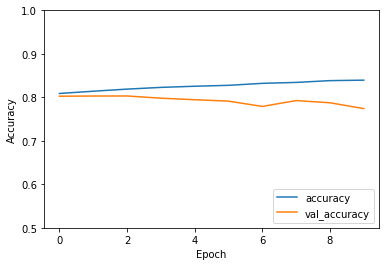

In [17]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

# Model Testing

In [18]:
test_loss, test_acc = DeepLOB_model.evaluate(testX_CNN, testY_CNN, verbose=2)

3122/3122 - 453s - loss: 1.1705 - accuracy: 0.5852


In [ ]:
DeepLOB_model.save('saved_model/my_model')

DeepLOB_model = load_model('saved_model/my_model')
DeepLOB_model.summary()

In [19]:
pred = DeepLOB_model.predict(valX_CNN)

from sklearn.metrics import f1_score

print('test_accuracy:', accuracy_score(valY_CNN.argmax(1)-1, pred.argmax(1)-1))
print('test_f1_score:', f1_score(valY_CNN.argmax(1)-1, pred.argmax(1)-1, average='weighted'))

2022-05-12 20:00:16.948203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


test_accuracy: 0.7741341341341341
test_f1_score: 0.7151553944639234


[[0.07198364 0.9202454  0.00777096]
 [0.03734171 0.95308605 0.00957224]
 [0.05501618 0.92839806 0.01658576]]


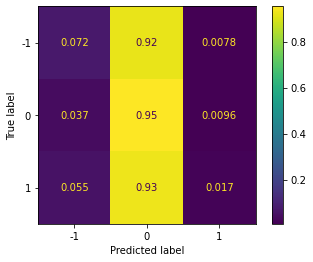

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(valY_CNN.argmax(1)-1, pred.argmax(1)-1, normalize='true')
print(cm)

ConfusionMatrixDisplay.from_predictions(valY_CNN.argmax(1)-1, pred.argmax(1)-1, normalize='true')
plt.show()